In [45]:
__author__ = "Philipp Kats"
__date__ = "2016_02_09"

%pylab inline


import matplotlib.pyplot as plt


import pandas as pd
from palettable.cubehelix import red_16_r

Populating the interactive namespace from numpy and matplotlib


In [5]:
def selfMatrix(l):
    '''all possible pairs of elements, once '''

    for i, l1 in enumerate(l):
        for l2 in l[i:]:
            yield (l1, l2)


In [4]:
! pwd

/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/code/ODMATRIX


In [11]:
import pickle
import os
path = os.getenv('PWD')+ '/code/EDA/zipJoined.pkl'
datum = pd.read_pickle(path)

In [12]:
# df = pd.read_csv('/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/code/ODMATRIX/data/2016_02_18_sintetic.csv', index_col=0)
# df = df[pd.notnull(df.postalCode)]

## Create Frame

every user presented as a row, every zipcode - as a column.
if user never posted in the zipcode, cell will be filled with NaN

therefore, when we filter the DF by df[(pd.notnull(pd[zipcode1])) & (pd.notnull(pd[zipcode2]))] we garantee that this user was in both zipcodes and we can get the sum of filtered rows

In [8]:
# first, aggregate by user_id and postal code, getting the sum of tweets from given user in given zipcode
g = df[['user_id','postalCode','id']].groupby(['user_id', 'postalCode']).agg('count')

In [9]:
# now, unstack the frame, getting all zipcodes as columns

frame = g.unstack()
frame.columns = [int(x) for x in frame.columns.droplevel().tolist()]
frame.head()

,83,10001,10002,10003,10004,10005,10006,10007,10009,10010,...,11432,11433,11434,11435,11436,11691,11692,11693,11694,11697
user_id,,,,,,,,,,,,,,,,,,,,,
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,NaN,2,6,4,NaN,NaN,NaN,NaN,13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def getValues(df, zip1, zip2):
    '''returns summ of values for both zipcodes
    only from users who were at both zipcodes,
    as two (zip, value) tuples'''
    
    return df[(pd.notnull(frame[zip1]))&(pd.notnull(frame[zip2]) )][[zip1, zip2]].sum().iteritems()
    

In [11]:
# test
for x in getValues(frame, 83, 10001):
    print x

(83, 5097.0)
(10001, 8244.0)


### Now lets create matrix of pairs

In [12]:
zipcodes = df.postalCode.dropna().astype(int).unique().tolist()
len(zipcodes)

242

In [13]:
matrix = []


for pair in selfMatrix(zipcodes):
    v1, v2 = getValues(frame, pair[0], pair[1])
    matrix.append({'zip1':v1[0], 'zip1_value':v1[1], 
                   'zip2':v2[0], 'zip2_value':v2[1] })


matrixDF = pd.DataFrame(matrix)
matrixDF.head(3)

,zip1,zip1_value,zip2,zip2_value
0,10304,536,10304,536
1,10304,12,11228,3
2,10304,77,10310,295


In [14]:
len(matrixDF)

29403

In [15]:
matrixDF.to_csv('matrix.csv')

## Users_Zipcode

In [47]:
def heatLinks(df, zipcode):
    users = df[df.postalCode==zipcode].user_id.unique().tolist()

    
    data =df[df.user_id.isin(users)][['postalCode','id']]
    
    result = data.groupby('postalCode').agg('count').reset_index().rename( columns={'id':'users'})
    return result
#     def addZip(x):
#         result[x.postalCode] = result.
    
#     data.apply(addZip, 1)

In [54]:
x = heatLinks(datum, '10007')

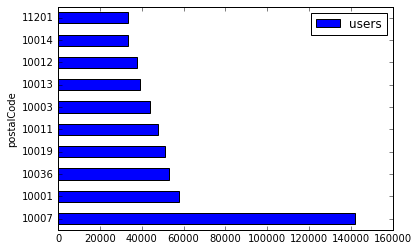

In [67]:
x.sort_values('users', ascending=0).head(10).set_index('postalCode').plot(kind='barh')

In [51]:
import geopandas as gp

zipPath = os.getenv('PWD') + '/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]


In [68]:
labelZip = zips.merge(x, how='left', on='postalCode')
labelZip[pd.isnull(labelZip.users)].users = 0

In [ ]:
def plotConnectivity(datum, zipcode):
    pC = str(zipcode)

    x = heatLinks(datum, pC)

    fig, ax = plt.subplots(figsize=(18,18))
    
    labelZip = zips.merge(x, how='left', on='postalCode')
    labelZip[pd.isnull(labelZip.users)].users = 0

    labelZip.plot(column='users', ax =ax, scheme='equal_interval', k=7, colormap=red_16_r.mpl_colormap, 
               alpha=1, legend=1)

    labelZip[labelZip.postalCode==pC].plot(ax=ax, color='red')
    
    plt.axis('off');
    plt.title('Zipcode connection for postCode %s' % pC, fontsize=20 )

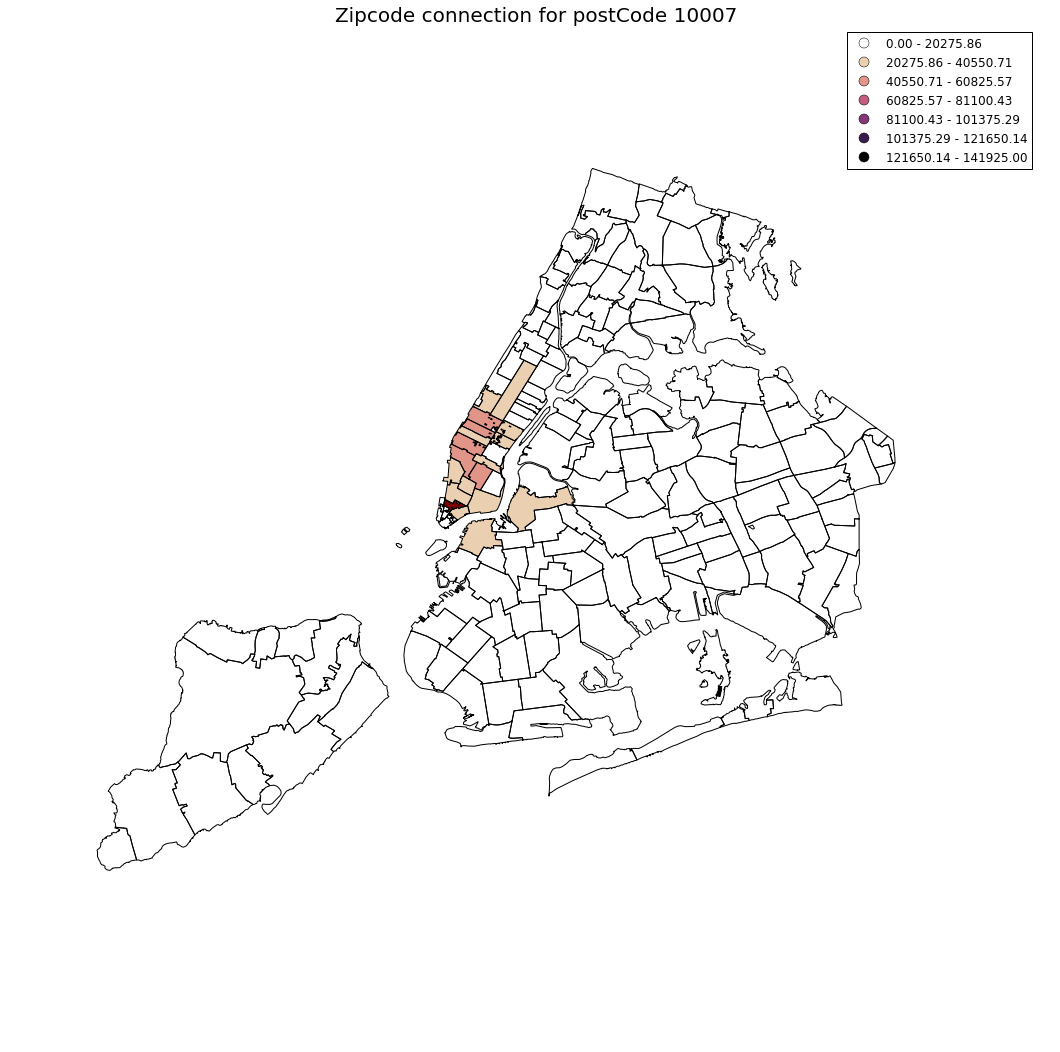

In [80]:
plotConnectivity(datum, 10007)

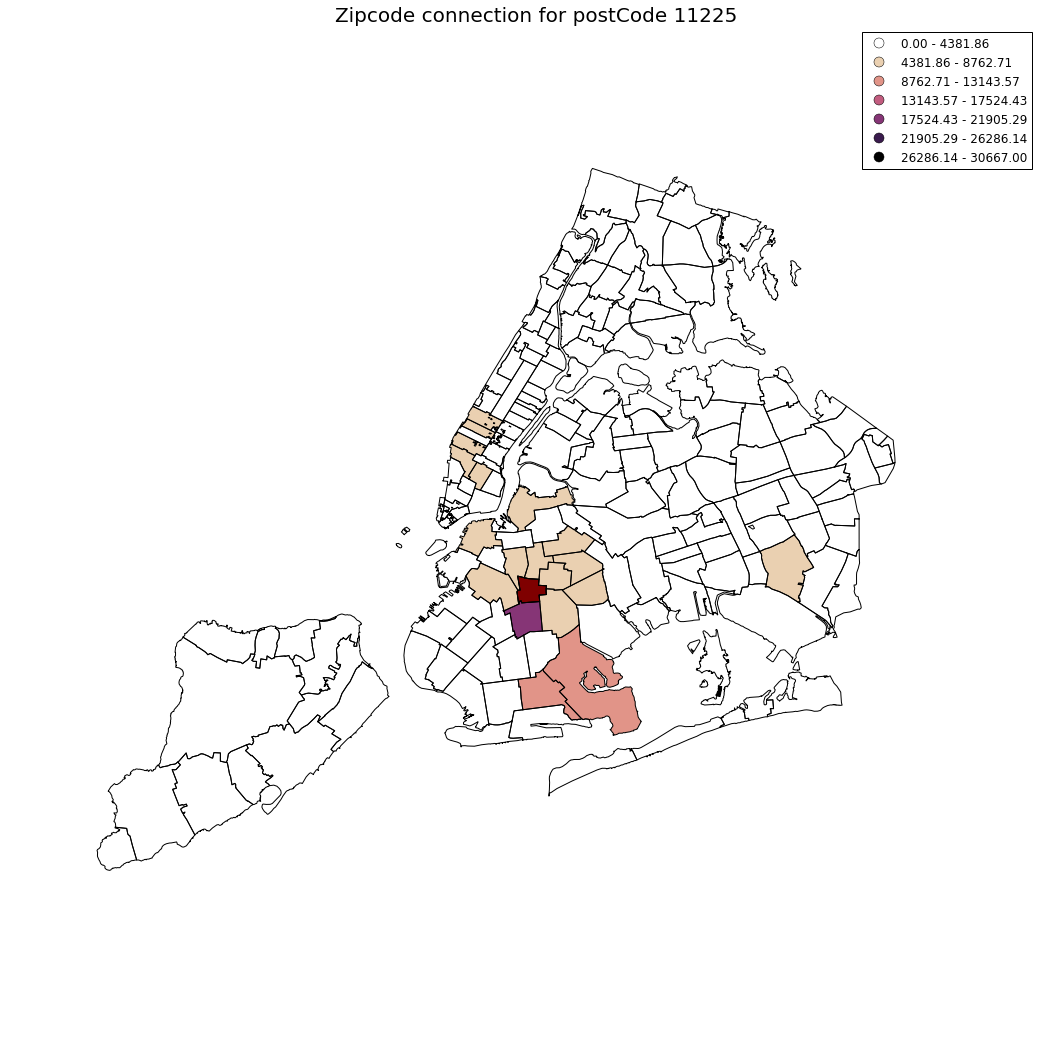

In [81]:
plotConnectivity(datum, 11225)